In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer/Breast_Cancer.csv


# Modelling packages

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

import shap # To use SHAP values
import matplotlib # To visualize SHAP values

# Loading the Breast Cancer data into Kaggle notebook

In [3]:
data = pd.read_csv("/kaggle/input/breast-cancer/Breast_Cancer.csv") 
data.head() # Prints out first five rows of data

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


# Preprocessing

In [4]:
data = data.drop(["Marital Status", "differentiate"], axis=1) # Drops the unnecessary columns
data["Survival Months"] = np.where(data["Survival Months"] > data["Survival Months"].max() // 2, 1, 0) # Translate column into binary values; makes it easier
data["Status"] = np.where(data["Status"] == "Alive", 1, 0) # Alive = 1, Dead = 0
data["Estrogen Status"] = np.where(data["Estrogen Status"] == "Positive", 1, 0) # Positive = 1, Negative = 0
data["Progesterone Status"] = np.where(data["Progesterone Status"] == "Positive", 1, 0)
data = pd.get_dummies(data) # One-hot encoding, changes categorical data into numerical data
data.head()

,Age,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Race_Black,Race_Other,...,6th Stage_IIB,6th Stage_IIIA,6th Stage_IIIB,6th Stage_IIIC,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3,A Stage_Distant,A Stage_Regional
0,68,4,1,1,24,1,1,1,False,False,...,False,False,False,False,False,False,False,True,False,True
1,50,35,1,1,14,5,1,1,False,False,...,False,True,False,False,False,False,True,False,False,True
2,58,63,1,1,14,7,1,1,False,False,...,False,False,False,True,False,False,True,False,False,True
3,58,18,1,1,2,1,1,1,False,False,...,False,False,False,False,False,False,False,True,False,True
4,47,41,1,1,3,1,0,1,False,False,...,True,False,False,False,False,False,False,True,False,True


# Predictive modelling
Using RandomForestClassifier

In [5]:
x = data.drop("Survival Months", axis=1)
y = data["Survival Months"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=0).fit(x_train, y_train)

# Making predictions based on model
y_pred = rf.predict(x_test)

# Checking the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8484472049689441


# Predictive Modelling
Using Logistic Regression

*Note: unfortunately SHAP values don't seem to support Logistic Regression yet*

In [6]:
x = data.drop("Survival Months", axis=1)
y = data["Survival Months"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train, y_train)

# Making predictions based on model
y_pred = logreg.predict(x_test)

# Checking the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8658385093167702


# Implementing SHAP Values
The graph below ranks each feature of the dataset, from highest importance to lowest importance.

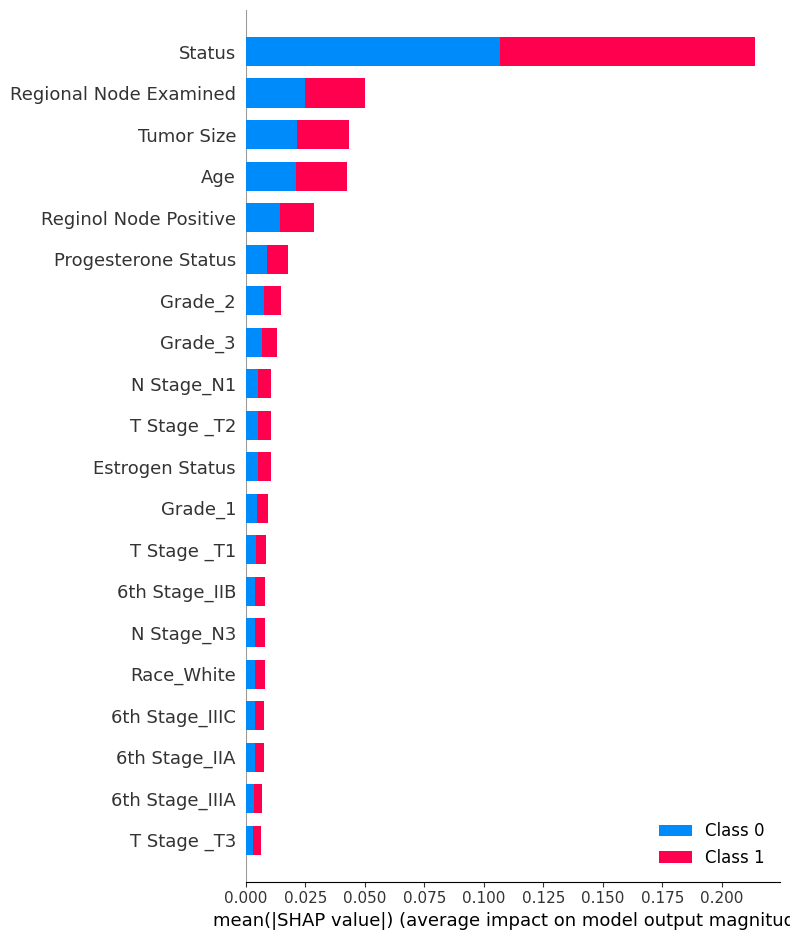

In [7]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(x_test)

shap.initjs()
shap.summary_plot(shap_values, x_test)

# Sampling Bias
Proof that datasets used to train predictive models are biased

In [8]:
white_pct = data["Race_White"].tolist().count(True) / len(data.axes[0]) * 100 # What percentage of people are White
black_pct = data["Race_Black"].tolist().count(True) / len(data.axes[0]) * 100 # What percentage of people are Black
other_pct = data["Race_Other"].tolist().count(True) / len(data.axes[0]) * 100 # What percentage of people are neither (Other)
print("Percentage of White people in dataset: ", white_pct)
print("Percentage of Black people in data: ", black_pct)
print("Percentage of neither White nor Black people in data: ", other_pct)

Percentage of White people in dataset:  84.81610337972168
Percentage of Black people in data:  7.231610337972167
Percentage of neither White nor Black people in data:  7.952286282306163
